## Simple Numerical Walkthrough

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

import pickle
import copy
import os

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [4]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
model_path='../models/2_1.pth'
model = BaarleNet([2])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
model

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

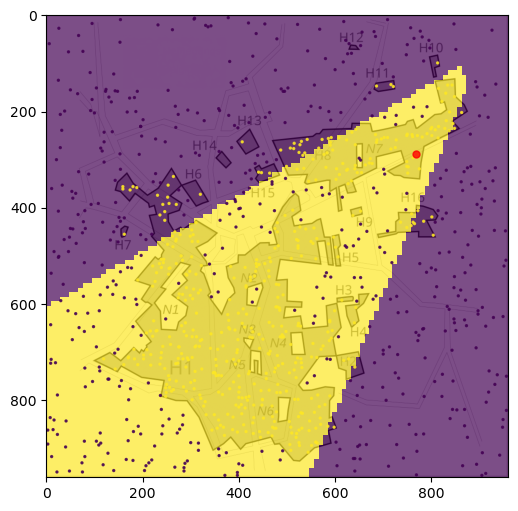

In [10]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)

ax.imshow(map.mean(2), cmap='gray')

X_denorm=denorm(X[:1000,:])
plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)

x_test=np.array([0.6, 0.4])
# x_test=np.array([-0.4, 0.3])
# x_test=np.array([-0.3, -0.5])
# x_test=np.array([0.3, 0.7])
X_denorm=denorm(x_test)
plt.scatter(X_denorm[0], X_denorm[1], c='r', s=25, alpha=0.8)


probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [11]:
with torch.no_grad():
    h1=model.model[:1](torch.tensor(x_test).float())
    h1r=model.model[:2](torch.tensor(x_test).float())
    h2=model.model[:3](torch.tensor(x_test).float())

In [12]:
print(x_test, h1, h1r, h2)

[0.6 0.4] tensor([-0.1416, -0.3275]) tensor([0., 0.]) tensor([-0.8848,  0.0332])


In [16]:
model.model[0].weight

Parameter containing:
tensor([[ 2.5135, -1.0248],
        [-1.4043,  2.4129]], requires_grad=True)

In [17]:
model.model[0].bias

Parameter containing:
tensor([-1.2398, -0.4501], requires_grad=True)

In [18]:
model.model[2].weight

Parameter containing:
tensor([[ 3.1702,  1.3257],
        [-3.4037, -1.5388]], requires_grad=True)

In [19]:
model.model[2].bias

Parameter containing:
tensor([-0.8848,  0.0332], requires_grad=True)

In [74]:
h1

tensor([-1.2031,  0.8177])

In [59]:
h1r

tensor([0., 0.])

In [60]:
h2

tensor([-0.8848,  0.0332])

In [61]:
h2

tensor([-0.8848,  0.0332])

In [62]:
_=extract_weights_to_numpy(model)

import numpy as np

w1 = np.array([[2.5135, -1.02481],
 [-1.4043, 2.41291]], dtype=np.float32)
b1 = np.array([-1.23981, -0.450078], dtype=np.float32)
w2 = np.array([[3.17024, 1.32567],
 [-3.40372, -1.53878]], dtype=np.float32)
b2 = np.array([-0.884835, 0.0332228], dtype=np.float32)
